# Procesamiento del Lenguaje Natural

## Generación de un modelo de lenguaje utilizando redes neuronales

Francisco Pablo Rodrigo

### Configuraciones previas

Se realizan los *imports* necesarios para hacer el análisis de nuestro *corpus*

In [1]:
#-*- encoding:utf-8 -*-
import nltk

import numpy as np
from collections import defaultdict, Counter
from itertools import chain

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from nltk.tokenize import sent_tokenize, word_tokenize

from tqdm import tqdm
from sklearn.decomposition import PCA
from operator import itemgetter

In [2]:
# Funcion que crea un vocabulario de palabras con un indice numero
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len (vocab)
    return vocab

# Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc]
        
#Función para visualizar los embeddings
#Usa reducción de la dimensionalidad por PCA
def plot_words(Z,ids):
    Z = PCA(2).fit_transform(Z)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    plt.show()

### Elección de un corpus

Un **corpus** es una muestra bien organizada del nuestro lenguaje tomada de materiales escritos o hablados y que se encuentran agrupados bajo un críterio común.

Para esta práctica se utilizará un corpus en *español*

In [3]:
# Se trabajara con el formato en palabras,teniendo en cuenta que hay otros formatos como sentencias o texto
# https://www.nltk.org/api/nltk.corpus.html
#sents = cess_esp.sents()

#nltk.download('punkt')
sents =  [word_tokenize(s) for s in sent_tokenize(open('corpus/funes_el_memorioso.txt','r').read())]

print(sents[:2])

[['FUNES', 'EL', 'MEMORIOSO', 'Jorge', 'Luis', 'Borges', 'Lo', 'recuerdo', '(', 'yo', 'no', 'tengo', 'derecho', 'a', 'pronunciar', 'ese', 'verbo', 'sagrado', ',', 'sólo', 'un', 'hombre', 'en', 'la', 'tierra', 'tuvo', 'derecho', 'y', 'ese', 'hombre', 'ha', 'muerto', ')', 'con', 'una', 'oscura', 'pasionaria', 'en', 'la', 'mano', ',', 'viéndola', 'como', 'nadie', 'la', 'ha', 'visto', ',', 'aunque', 'la', 'mirara', 'desde', 'el', 'crepúsculo', 'del', 'día', 'hasta', 'el', 'de', 'la', 'noche', ',', 'toda', 'una', 'vida', 'entera', '.'], ['Lo', 'recuerdo', ',', 'la', 'cara', 'taciturna', 'y', 'aindiada', 'y', 'singularmente', 'remota', ',', 'detrás', 'del', 'cigarrillo', '.']]


### Limpiar el corpus: eliminar signos de puntuación, de interrogación, admiración y elementos no léxicos.

Para tener un análisis más limpio de los tipos y morfemas se descartan signos de puntuación y algunos otros elementos no léxicos que se muestran a continuación.

In [4]:
# # Se declaran elementos no lexicos con base en el idioma del corpus
# non_lexical_list = ['¡','!','?','¿','.',',',';',':','-','_','(',')','""',"'",'-','#','/','&','$','*','"',
#                     '-fpa-','-fpt-','*0*','-Fpa-','-Fpt-','-fe-']

# # Se crea una nueva lista sin los elementos lexicos
# corpus_without_non_lexical = []

# for sent in sents:
#     corpus_without_non_lexical.append([w.lower() for w in sent if w not in non_lexical_list])
    
# print(corpus_without_non_lexical[:2])

In [5]:
#Split en corpus train y test
corpus, corpus_eval = train_test_split(sents, test_size=0.3)

print('Número de cadenas train:',len(corpus))
print('Número de cadenas test:',len(corpus_eval))


#Frecuencia de los tipos
freq_words= Counter( chain(*[' '.join(sent).lower().split() for sent in corpus]) )

print('Número de tipos: {} \nNúmero de tokens: {}'.format(len(freq_words), sum(freq_words.values())))

Número de cadenas train: 88
Número de cadenas test: 39
Número de tipos: 836 
Número de tokens: 2144


In [6]:
# plt.figure(figsize=(20,3),dpi=120)
# plt.xticks(size=15)
# plt.yticks(size=15)
# freq_words.plot(40)

### Sustitución de los hapax

Ahora sustituiremos elementos del texto por el símbolo de fuera del vocabulario (Out Of Vocabulary) o $OOV$ esto nos permitirá manejar elementos que no se observen durante el entrenamiento.

In [7]:
#Nuevo corpus remplazando hápax por OOV
corpus_hapax = []
#Reemplazamos los hápax por OOV
for sent in corpus:
  sent_hapax =[]
  for w in sent:
    #Si es hápax
    if freq_words[w.lower()] == 1:
      #Se reemplaza por <oov>
      sent_hapax.append('<oov>')
    else:
      #De otra forma se mantiene la palabra en mínuscula
      sent_hapax.append(w.lower())
  #Se agrupan las cadenas    
  corpus_hapax.append(sent_hapax)
    
#print(corpus_hapax)

### 1.  Stemming

Para esta tarea no realiza el procesos de steamming con la finalidad de simplificar la validación del modelo, ya que de otra manera se deberían reconstruir las cadenas a la hora de evaluar el modelo o a la hora de usarlo para alguna aplicación, por ejemplo, la generación de oraciones.

### 2. Insertar símbolos de inicio y final de cadena

Se indexa cada simbolo del vocabulario previamente tratado (sin _stopwords_ y _estemmizado_) para tener un modelo de entrenamiento.

In [8]:
# Llamamos a la funcion para crear un vocabulario
idx = vocab() # Simplemente se renombra la funcion

# sents_corpus = []

# for sent in corpus_hapax:
#     sents_corpus.append(" ".join(sent)) # Can make it better
   

#cads_idx = list(text2numba(sents_corpus,idx))
cads_idx = list(text2numba(corpus_hapax,idx))
#print(cads_idx[:3])

#print(idx)

Además, se colocarán etiquetas al inicio y al final de cada sentencia: BOS (Beginning of Sentence) y EOS (End of Sentence) respectivamente.

In [9]:
BOS = '<BOS>'
EOS = '<EOS>'

# A cada etiqueta se le asigna el indice número mayor 
# que el último indice asignado al vocabulario

BOS_IDX = max(idx.values()) + 2
EOS_IDX = max(idx.values()) + 1

# Se agregan las etiquetas al vocabulario
idx[EOS] = EOS_IDX
idx[BOS] = BOS_IDX

# Agregamos las etiquetas BOS al inicio y EOS al final de cada sentencia

strings = [[BOS_IDX] + cad + [EOS_IDX] for cad in cads_idx]

print(strings[:2])

[[463, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 11, 21, 22, 11, 23, 12, 24, 15, 11, 25, 11, 26, 27, 28, 29, 30, 21, 22, 31, 18, 32, 33, 11, 22, 25, 34, 18, 35, 22, 36, 11, 1, 37, 38, 39, 40, 1, 41, 22, 42, 18, 11, 28, 43, 44, 45, 462], [463, 6, 7, 18, 22, 46, 11, 24, 11, 24, 11, 11, 18, 11, 38, 47, 45, 462]]


### 3. Bigramas

Antes de entrenar el modelo del lenguaje obtendremos los pares de entrenamiento que serán los pares obtenidos de bigramas, de tal forma que nuestro conjunto supervisado será:

$$\mathcal{S} = \{(i,j) : (w_i, w_j) \text{ es un bigrama}\}$$
Antes de obtener estos bigramas, además, debemos agregar los símbolos de $BOS$ y $EOS$, así como crear el vocabulario:

In [10]:
# Creacion de bigramas

bigrams = list(chain(*[zip(cad,cad[1:]) for cad in strings]))
print(len(bigrams))
# print(bigrams[:5])

3256


### 4. Entrenamiento de la red neuronal

In [11]:
np.random.seed(0)

# dim -> hiperparametro que define la dimensioón de los vectores-palabra
dim = 100
m = 300
N = len(idx)

# Se usa para generar vectores one-shot
matrix_I = np.identity(N)

# Embebidding
C = np.random.randn(dim,N) / np.sqrt(N)

# Oculta
W = np.random.randn(m,dim) / np.sqrt(dim)
b = np.ones(m)

# Salida
U = np.random.randn(N,m) / np.sqrt(m)
c = np.ones(N)

#V = np.random.randn(N,dim) / np.sqrt(dim)

iterations = 100
eta = 0.1

for i in tqdm(range(0,iterations)):    
    for bigram in bigrams:
        
        # FOWARD       
        
        # Capa embbeding
        c_i = C.T[bigram[0]]
        
        # Capa oculta
        h_i = np.tanh(np.dot(W,c_i) + b)
        
        # Pre-activacion
        a = np.dot(U,h_i) + c
        
        # Salidas
        tmp = np.exp(a - np.max(a))
        # Aplicando softmax
        f = tmp/tmp.sum(0)
        
        # BACKPROPAGATION para salida
        d_out = f
        k= bigram[1]
        d_out[k] -= 1
     
        # Backpropagation para la capa oculta
        dh = (1-h_i**2)*np.dot(U.T,d_out) 
        
        # Backpropagation para la capa embedding
        dc = np.dot(W.T,dh)
        c -= eta*d_out

        # Actualizacion de la capa de salida
        U -= eta*np.outer(d_out,h_i)
        
        # Actualizacion de capa oculta
        W -= eta*np.outer(dh,c_i)
        b -=eta*dh
        
        # Actualizacion embedding
        C -= eta*np.outer(dc,matrix_I[bigram[0]].T)
        break

100%|██████████| 100/100 [00:00<00:00, 651.41it/s]


### 5. Evaluación del modelo

Entrenada la red, definimos una función forward para obtener las probabilidades a partir de la red ya entrenada.

In [12]:
def forward(x):
    # Capa embbeding
    c_i = C.T[x]
    # Capa oculta
    h_i = np.tanh(np.dot(W,c_i) + b)
    # Pre-activacion
    a = np.dot(U,h_i) + c
    # Salidas
    tmp = np.exp(a - np.max(a))
    # Aplicando softmax
    f = tmp/tmp.sum(0)
    
    return f

In [13]:
#idx.popitem()

In [14]:
lista = []

for word in idx.keys():
    lista.append((word,forward(idx['de'])[idx[word]]))
    #print(word,forward(idx['presidente'])[idx[word]])

lista.sort(key=lambda x: x[1],reverse=True)

lista[:10]

[('funes', 0.9999800014184309),
 ('vanagloria', 2.3632618452225738e-07),
 ('bentos', 2.303653061800238e-07),
 ('indirecto', 2.0900645430777195e-07),
 ('tentación', 1.9372222836168304e-07),
 ('elementos', 1.8979238225471458e-07),
 ('pero', 1.6044799100366072e-07),
 ('primos', 1.588057824439124e-07),
 ('perentorio', 1.5229875020877716e-07),
 ('visto', 1.5194470021902708e-07)]

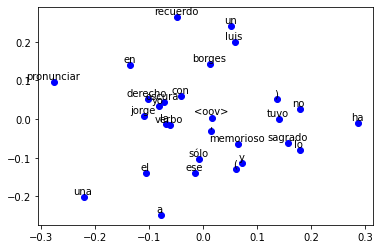

In [15]:
label = [w[0] for w in sorted(idx.items(), key=itemgetter(1))]
plot_words(C.T[1:30],label[1:30])

Para evalaur el modelo, necesitamos primero definir una función que nos de la probabilidad de las cadenas. Definimos esta función a continuación

In [16]:
def prob_sent(sent):
    #Obtenemos los simbolos
    seq = sent.split()
    #Obtenemos los bigramas de la cadena de evaluacion
    bigrSeq = zip(seq,seq[1:])
    
    #Guardamos la probabilidad inicial dado el modelo
    try:
        p = forward(idx['<BOS>'])[idx[seq[0]]]
    except: 
        p = forward(idx['<BOS>'])[idx['<oov>']]
    #Multiplicamos por las probabilidades de los bigramas dado el modelo
    for gram1, gram2 in bigrSeq:
        #Obtiene las probabilidades de transición
        #Dado el primer elemento
        try:
            prev_prob = forward(idx[gram1])
        #En caso de que sea una OOV
        except:
            prev_prob = forward(idx['<oov>'])
        #Obtiene la probabilidad de transitar a la siguiente palabra
        try:
            p *= prev_prob[idx[gram2]]
        #En caso de que sea una OOV
        except:
            p *= prev_prob[idx['<oov>']]
            
    return p

In [17]:
prob_sent('lo veo en un atardecer')

3.7002183642725037e-37

Ya con esto, podemos evaluar el modelo con entropía empírica (tomamos el promedio por cadena de ésta). Asimismo, con base en la entropía empírica podemos obtener la perplejidad como:

In [18]:
#Evaluación del modelo
H = 0.0
for cad in corpus_eval:
    #Probabilidad de la cadena
    p_cad = prob_sent(' '.join(cad))
    #Longitud de la cadena
    M = len(cad)
    #Obtenemos la entropía cruzada de la cadena
    if p_cad == 0:
        pass
    else:
        H -= (1./M)*(np.log(p_cad)/np.log(2))
        
H = H/len(corpus_eval)

print('Entropía promedio: {}\nPerplejidad total: {}'.format(H,2**H))

Entropía promedio: 20.112004411267378
Perplejidad total: 1133226.1841811107


In [19]:
# 6. Calcular la proabilidad de 5 oraciones no vistas en el entrenamiento.
# 7. Guardar los vectores de la capa de embedding asociados a las palabras